In [1]:
%matplotlib notebook

import logging
import time

from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np

import qcodes
from qcodes.utils.helpers import LogCapture

In [2]:
%run -i ./init_station.py

C:\Users\Administrator\Anaconda3\envs\qcodes\lib\site-packages\pyvisa\ctwrapper\functions.py:1225: VisaIOWarning: VI_WARN_CONFIG_NLOADED (1073676407): The specified configuration either does not exist or could not be loaded. VISA-specified defaults will be used.
  ret = library.viOpenDefaultRM(byref(session))


Connected to: TEKTRONIX AWG5208 (serial:B020202, firmware:FV:6.1.0054.0) in 0.17s


In [3]:
setup_alazar_ext_trigger(384, 1, 1)

<IPython.core.display.Javascript object>


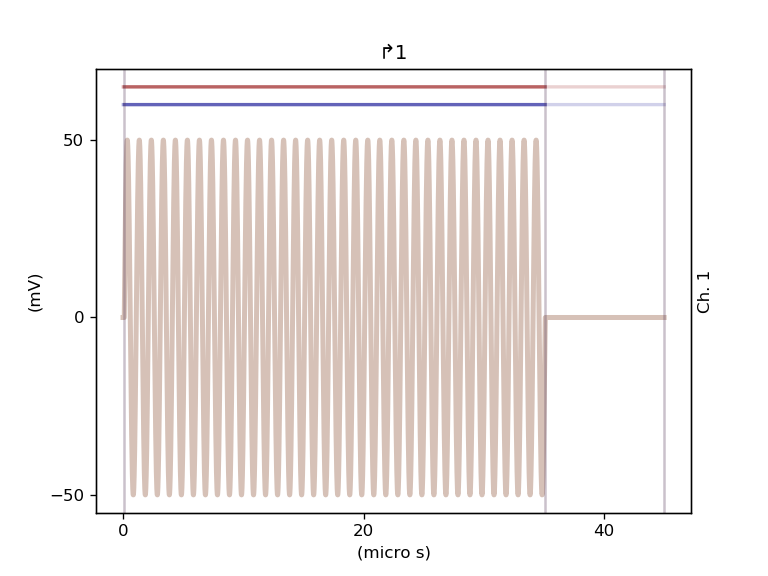

Waveforms done
['wfm_1_1_1']
True debug
[['wfm_1_1_1']]


True

In [4]:
from alazar_benchmarking import benchmark
benchmark.make_test_sequence_5208(station.awg5208_1, plot=True)

In [5]:
ats_logger = qcodes.instrument_drivers.AlazarTech.ATS.logger
ats_logger.setLevel(logging.DEBUG)

# Define acquisition controllers

In [6]:
# Features to add:
# - min samples per record depending on model
# - bits per sample depending on model
# - buffer order depending on model
# - "per model" stuff should be in the driver
# - pass alazar not via name, but via instance
# - rename buffer_order to dimension_order or smth
# - ...

In [48]:
from qcodes.instrument_drivers.AlazarTech.ATS import AlazarTech_ATS, AcquisitionController
from qcodes.instrument.base import Instrument
from qcodes.config.config import DotDict


# Info from these dicts will be part of each driver class
MIN_SAMPLES_PER_RECORD_PER_MODEL = {
    'ATS9373': 256,
    'default': 256,
}
BUFFER_ORDER_PER_MODEL = {
    'default': 'brsc',
    'ATS9373': 'brsc',
    'ATS9870': 'bcrs',
}
DATA_DTYPE_PER_BITS_PER_SAMPLES = {
    8: np.uint8,
    12: np.uint16,
}


class AcquisitionManager(Instrument):
    """
    This class shall be used to set up and perform acquisitions with Alazar cards.
    
    The idea is that this class is an user-friendly interface that refers behind
    the scenes to different Acquisition Controllers and Alazar drivers, and takes
    care of selecting/constructing a correct Acquisition Controller, and executing
    the acquisition.
    
    To refactor:
    - more than one main responsibility:
        * account for Alazar board models differences
        * manage infromation about the output data (dtype, shapes, etc.)
        * setup acquisition based on non-Alazar related parameters
        * launch the acquistion
        * ...
    
    Args:
        name
            Name of the Acquisition Manager; it is required because it is a qcodes
            Instrument, and is intended to be snapshotted
        alazar_instr_name
            Name of an existing Alazar intrument driver instance to use for acquisition
    """
    def __init__(self,
                 name: str, 
                 alazar_instr_name: str,
                 **kwargs  # Instrument-related kwargs...
                ):
        super().__init__(name, **kwargs)
        
        self._alazar = None
        self._alazar_info = DotDict()  # contains 'model', 'bits_per_sample', etc.
        self.use_alazar(alazar_instr_name)
        
    def use_alazar(self, alazar_instr_name: str) -> None:
        """
        Assigns an instance of Alazar instrument driver to perform acquisition with
        
        Args:
            alazar_instr_name
                Name of an existing Alazar intrument driver instance
        """
        self._alazar = self.find_instrument(alazar_instr_name,
                                            instrument_class=AlazarTech_ATS)
        self._alazar_info = DotDict(self._alazar.get_idn())
        self._set_data_dtype()
        
    @property
    def number_of_channels(self) -> int:
        """Total number of channels on the current Alazar card"""
        return self._alazar.channels
    
    @property
    def min_samples_per_record(self) -> int:
        # This property in the future will do:
        # return self._alazar.MIN_SAMPLES_PER_RECORD
        # but for now:
        return MIN_SAMPLES_PER_RECORD_PER_MODEL[self._alazar_info.model]
    
    @property
    def buffer_order(self) -> str:
        """
        String that represents the order of dimensions within a buffer:
            'bcrs' - channels, records, samples
            'brsc' - records, samples, channels
        
        This is crucial for reshaping the 1D array of acquired data into
        useful multidimensional array.
        """
        # This property in the future will do:
        # return self._alazar.BUFFER_ORDER
        # but for now:
        buffer_order = BUFFER_ORDER_PER_MODEL.get(self._alazar_info.model, None)
        if buffer_order is None:
            raise ValueError('Unknown buffer order {}'.format(buffer_order))
        return buffer_order
    
    @property
    def data_dtype(self) -> np.dtype:
        """Numpy dtype of the acquired data"""
        return self._data_dtype
    
    def _set_data_dtype(self) -> None:
        """
        Sets data_dtype based on number of bits per sample
        from _alazar_info property
        """
        bits_per_sample = self._alazar_info.bits_per_sample
        
        self._data_dtype = DATA_DTYPE_PER_BITS_PER_SAMPLES.get(bits_per_sample, None)
        if self._data_dtype is None:
            raise ValueError(f'Unsupported number of bits per sample: {bits_per_sample}')
    
    @property
    def buffer_shape(self):
        if self.buffer_order == 'brsc':
            buffer_shape = (self._alazar.records_per_buffer(),
                            self._alazar.samples_per_record(),
                            self.number_of_channels,)
        elif self.buffer_order == 'bcrs':
            buffer_shape = (self.number_of_channels,
                            self._alazar.records_per_buffer(),
                            self._alazar.samples_per_record(),)
        return buffer_shape
    
    @property
    def acquisition_shape(self):
        return (self._alazar.buffers_per_acquisition(), *self.buffer_shape)
    
    @property
    def samples_per_record_multiple(self):
        return self._alazar.samples_divisor
    
    def time2samples(self, t):
        nsamples_ideal = t * self.sample_rate()
        nsamples = int(nsamples_ideal // 128 * 128)
        if nsamples / self.sample_rate() < t:
            nsamples += 128
        return max(self.MIN_SAMPLES_PER_RECORD, nsamples)

    def setup_acquisition(self, n_points, record_time, sample_rate, allocated_buffers=5):
        """
        TODO: There should 1 user API function like this with many kwargs,
        and its implementation forwards according to kwargs to more specific
        setup functions.
        
        The acquisition is set up in the following way:
        1. record_time, sample_rate -> define samples_per_record
        2. n_points, MB size of samples_per_record -> define records_per_buffer and buffers_per_acquisition,
           through recommended MB buffer size of 1-8MB (~7MB)
        
        Args:
            n_points
                number of measurement points, each corresponds to one trigger event;
                basically total number of records in acquisition
            record_time
                length of 1 record in time, in seconds
            sample_rate
                sample rate of Alazar
            n_dma_buffers
                number of DMA buffers used for data transfer from Alazar card
        """
        samples_per_record = int(record_time * sample_rate 
                                 // self.samples_per_record_multiple
                                 * self.samples_per_record_multiple)
        actual_record_time = samples_per_record / sample_rate
        
        record_size_in_MB = samples2MB(samples_per_record * self.number_of_channels, self.data_dtype)
        records_per_buffer = int(7 // record_size_in_MB)  # buffer should be betwee 1 and 8 MB
        
        buffers_per_acquisition = int(n_points // records_per_buffer)
        
        # actually, driver.acquire function is smart to correct for this as well...
        if allocated_buffers > buffers_per_acquisition:
            allocated_buffers = buffers_per_acquisition

        with self._alazar.syncing():
            self._alazar.sample_rate(sample_rate)
            self._alazar.samples_per_record(samples_per_record)
            self._alazar.records_per_buffer(records_per_buffer)
            self._alazar.buffers_per_acquisition(buffers_per_acquisition)
            self._alazar.allocated_buffers(allocated_buffers)
            
        # Print size information
        mbpr = record_size_in_MB
        mbpb = mbpr * records_per_buffer
        mbpa = mbpb * buffers_per_acquisition
        size_of_all_allocated_buffers = allocated_buffers * mbpb
                
        print(f'Setup capture: {mbpa} MB total')
        print(f' * Buffers: {buffers_per_acquisition} ({mbpb} MB/buffer)'
              f' | (Allocated buffers: {size_of_all_allocated_buffers} = {size_of_all_allocated_buffers} MB)')
        print(f' * Records: {records_per_buffer} ({mbpr} MB/record)') 
        print(f' * Samples: {samples_per_record} (= {actual_record_time*1e6} us)')
        print(f' * Channels: {self.number_of_channels}')
    
    def _choose_controller(self) -> AcquisitionController:
        """
        This method returns a proper Acquisition Controller the meets
        the settings of the Manager.
        """
#         ctl = instools.create_inst(EmptyAcqCtl,
#                                    'empty_acqctrl_from_manager_' + self.name,
#                                    self._alazar.name,
#                                    force_new_instance=True)
        ctl = instools.create_inst(RawDataAcqCtl,
                                   'rawdata_acqctrl_from_manager_' + self.name,
                                   self._alazar.name,
                                   DataCollector(self.acquisition_shape, self.data_dtype),
                                   force_new_instance=True)
        return ctl
    
    def do_acquisition(self):
        controller = self._choose_controller()
        return self._alazar.acquire(acquisition_controller=controller)


class EmptyAcqCtl(AcquisitionController):
    def pre_start_capture(self):
        pass

    def pre_acquire(self):
        pass

    def handle_buffer(self, buffer, buffer_number=None):
        pass
    
    def buffer_done_callback(self, buffers_completed):
        pass

    def post_acquire(self):
        return None


class DataCollector:
    """
    A class that encapsulates a large buffer in the PC memory for the 
    data that is being acquired.
    
    It takes care of:
    - allocating correct 1D array to fit the number of elements
      from the shape argument
    - returning the raw 1D array of all data
    - returning the data as a shaped array according to the
      shape argument that was passed to the costructor
      
    Args:
        shape
            shape of the final data as a tuple of integers
    """
    def __init__(self, shape: 'Tuple[int]', dtype: np.dtype):
        self._shape = shape
        self._unshaped_data = np.zeros((np.prod(shape)), dtype=dtype)
        self._index_of_last_valid_element = 0
        print(f'Allocated {self._unshaped_data.size} elements ({samples2MB(self._unshaped_data.size)} MB)')
    
    @property
    def unshaped_data(self):
        return self._unshaped_data
    
    @property
    def data(self):
        return self._unshaped_data.reshape(self._shape)
    
    def append(self, chunk_1d):
        """Append a 1D chunk to the complete data"""
        # TODO: do we HAVE to copy() "chunk_1d"?
        n_new_points = chunk_1d.size
        self._unshaped_data[
            self._index_of_last_valid_element 
            : self._index_of_last_valid_element + n_new_points] = chunk_1d
        self._index_of_last_valid_element += n_new_points


class RawDataAcqCtl(AcquisitionController):
    def __init__(self, name, alazar_name, data_collector, **kwargs):
        super().__init__(name, alazar_name, **kwargs)
        self._data_collector = data_collector
        
    def pre_start_capture(self):
        pass

    def pre_acquire(self):
        pass

    def handle_buffer(self, buffer, buffer_number=None):
        self._data_collector.append(buffer)
    
    def buffer_done_callback(self, buffers_completed):
        pass

    def post_acquire(self):
        return self._data_collector.data


def samples2MB(n, dtype=np.uint16):
    """Calculate how much memory in PC a given number of samples will take"""
    #     -n- -mega- --------------------bytes-------
    return n * 1e-6 * np.dtype(dtype).itemsize
                
    
    

##########################################################################################
##########################################################################################
# IDEA ABOUT HOW TO UNIFORMLY HANDLE BUFFERS
##########################################################################################
                
#     def handle_buffer(self, data, buffer_number=None):
#         t0 = time.perf_counter()
        
# #         data = np.copy(data1)
        
#         # Note that reshaping here before and after `process_buffer` 
#         # does not seem to have an effect on performance
# #         data.shape = self.buffer_shape  # use this so that process_buffer works with shaped array rather than 1D thing
        
# #         if self._buffer_order == 'bcrs':  # use this so that process_buffer works with shaped array rather than 1D thing
# #             data = data.transpose((1,2,0))  # use this so that process_buffer works with shaped array rather than 1D thing
        
#         data = self.process_buffer(data)
        
# #         data = data.reshape(-1)  # use this so that process_buffer works with shaped array rather than 1D thing
        
#         n = data.size
#         self.data[buffer_number*n : (buffer_number+1)*n] = data
        
#         self._handling_times[buffer_number] = (time.perf_counter() - t0) * 1e3
    
#     def process_buffer(self, buf):
#         """
#         Implement this method to perform operation inside the default
#         `handle_buffer` method of this class that is to be common for all
#         acquisition controllers.
#         """
#         raise NotImplementedError


##########################################################################################
##########################################################################################
# IDEA ABOUT CONVERTING TO VOLTS (there are other implementations, even in the driver)
##########################################################################################


#         if self.CONVERT_TO_VOLTS:
#             if self._nbits == 12:
#                 data = np.right_shift(buf, 4)
#             data = (data.astype(np.float32) / (2**self._nbits)) - 0.5
#             return data
    
    
acqmgr = instools.create_inst(AcquisitionManager, 'acqmgr', 'alazar', force_new_instance=True)
station = add2station(station, acqmgr)

Instrument acqmgr already exists.


# Effect of breaking up into buffers

Here we measure overhead of raw acquisition controller depending on SR and number of records per buffer.

In [49]:
# acqmgr = station.acqmgr
# ctl.CONVERT_TO_VOLTS = True

In [50]:
def time_acquisition(acqmgr, n_points, record_time, sample_rate, allocated_buffers=5):
    t_net_total = n_points * t_rep
    t_net_meas_total = n_points * t_meas
    
    acqmgr.setup_acquisition(n_points, record_time, sample_rate, allocated_buffers=5)
    
    with LogCapture(logger=ats_logger) as logs:
        t0 = time.perf_counter()
        
        data = acqmgr.do_acquisition()
        
        t1 = time.perf_counter()
    log_str = logs.value
    
    t_acq_total = t1 - t0
    overhead = t_acq_total / t_net_total
    overhead_meas = t_acq_total / t_net_meas_total

    print(f'Net meas time: {t_net_meas_total:.6f} sec.')
    print(f'Net time: {t_net_total:.6f} sec.')
    print(f'Acquistion: {t_acq_total:.6f} sec.')
    print(f'Overhead meas: {overhead_meas:.2f} X')
    print(f'Overhead: {overhead:.2f} X')
    
    print('\n', log_str)
    
    return t_acq_total, data

In [58]:
t_rep = 45e-6  # this is the rep-rate of the AWG test sequence
t_meas = 43e-6  # this is the time of the useful signal that we are measuring
t_acq = t_meas  # time it takes to measure raw data by Alazar 
#                  # for a single measurement point (i.e. it is to be demodulated later)
n_points = 100_000  # number of "measurement points"

t, d = time_acquisition(acqmgr,
                        n_points=50000, 
                        record_time=36e-6, 
                        sample_rate=20e6, 
                        allocated_buffers=5)

Setup capture: 125.98271999999999 MB total
 * Buffers: 18 (6.999039999999999 MB/buffer) | (Allocated buffers: 34.9952 = 34.9952 MB)
 * Records: 2734 (0.0025599999999999998 MB/record)
 * Samples: 640 (= 32.0 us)
 * Channels: 2
Allocated 62991360 elements (125.98272 MB)
Net meas time: 2.150000 sec.
Net time: 2.250000 sec.
Acquistion: 2.347661 sec.
Overhead meas: 1.09 X
Overhead: 1.04 X

 buffers cleared
buffers cleared
Captured 18 buffers (7.866997 buffers per sec)
Captured 49212 records (21508.368873 records per sec)
Transferred 1.25983e+08 bytes (5.50614e+07 bytes per sec)
    allocating buffers took 0.0009403811086485803
  Pre setup took 0.05369458826316986
  AcqCtrl.pre_start_capture took 5.865162847840111e-06
  AlazarStartCapture took 8.699991531102569e-05
  AcqCtrl.pre_acquire took 2.932581537606893e-06
  Pre capture setup took 0.00010508416744414717
  Capture took 2.2277335202365975
    async wait calls took (s): 0.11104026754696861 +- 0.003042927898571847
    handle buffer calls 

<IPython.core.display.Javascript object>


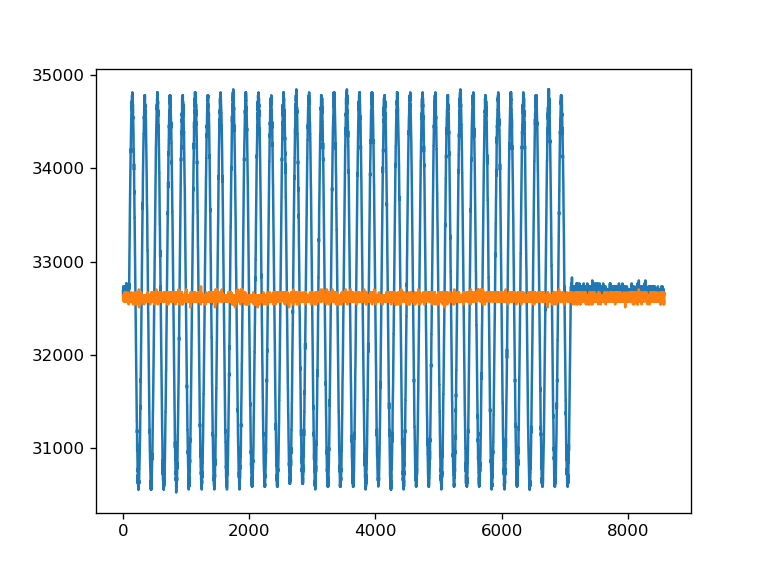

In [11]:
fig, ax = plt.subplots(1,1)
ax.plot(d[1][1])

In [18]:
34.56*250

8640.0

In [59]:
reference_acq_start_moment = 1146.421274607413
dll_wait_calls_moments = [1146.5448218187967, 1146.6678670699944, 1146.7908766414514, 1146.9139165162496, 1147.0369524809394, 1147.15995569847, 1147.2830092586482, 1147.4060334930125, 1147.5290494183957, 1147.6520844055585, 1147.7751052185774, 1147.898136784395, 1148.0211536873057, 1148.144203826139, 1148.2672471222822, 1148.3902498510492, 1148.5132750629405, 1148.6362587299284]
handle_buffer_calls_moments = [1146.5568317172365, 1146.6800001368538, 1146.802412927992, 1146.926227004285, 1147.0488744019367, 1147.1720623720967, 1147.295554353197, 1147.4178434871521, 1147.5413242266904, 1147.664308382442, 1147.7868638925424, 1147.910622738552, 1148.0327784400524, 1148.156614510706, 1148.2793909419402, 1148.402065710352, 1148.525752219353, 1148.6484069484584]
dll_repost_calls_moments = [1146.557372289745, 1146.6805905632461, 1146.8029618094808, 1146.9267910374447, 1147.0494496766585, 1147.1726361805277, 1147.2961232739926, 1147.4183987225676, 1147.541872619416, 1147.6648523762951, 1147.7874186391944, 1147.9111848166574, 1148.0333199900879, 1148.1571848977921, 1148.2799593739721, 1148.4026263221665, 1148.5262918143344, 1148.6489499647846]

<IPython.core.display.Javascript object>


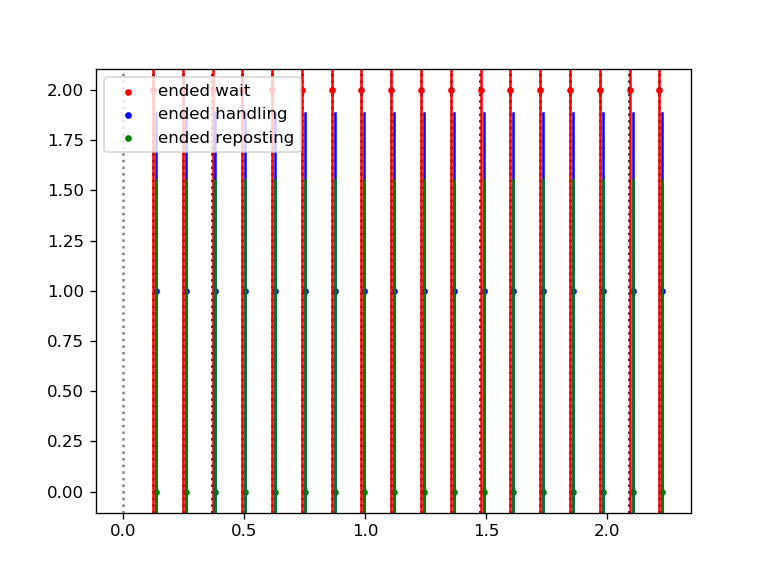

In [61]:
rec_per_buf = 2734 

dll_wait_calls_moments = np.array(dll_wait_calls_moments)
handle_buffer_calls_moments = np.array(handle_buffer_calls_moments)
dll_repost_calls_moments = np.array(dll_repost_calls_moments)

# reference_acq_start_moment = dll_wait_calls_moments[0]
dll_wait_calls_moments_rel = dll_wait_calls_moments - reference_acq_start_moment
handle_buffer_calls_moments_rel = handle_buffer_calls_moments - reference_acq_start_moment
dll_repost_calls_moments_rel = dll_repost_calls_moments - reference_acq_start_moment

fig, ax = plt.subplots(1,1)

plt.axvline(x=0, color='gray', ymax=1, linestyle=':')
for i in range(len(dll_wait_calls_moments_rel)):
    plt.axvline(x=(i+1)*t_rep*rec_per_buf, color='black', ymax=1, linestyle=':')

ax.scatter(dll_wait_calls_moments_rel, [2]*len(dll_wait_calls_moments_rel), label='ended wait', marker='.', color='red')
for xx in dll_wait_calls_moments_rel:
    plt.axvline(x=xx, color='red')
    
ax.scatter(handle_buffer_calls_moments_rel, [1]*len(handle_buffer_calls_moments_rel), label='ended handling', marker='.', color='blue')
for xx in handle_buffer_calls_moments_rel:
    plt.axvline(x=xx, color='blue', ymax=0.90)
    
ax.scatter(dll_repost_calls_moments_rel, [0]*len(dll_repost_calls_moments_rel), label='ended reposting', marker='.', color='green')
for xx in dll_repost_calls_moments_rel:
    plt.axvline(x=xx, color='green', ymax=0.75)
    
ax.legend()

In [ ]:
nrecords = np.array([10, 20, 50, 100, 200, 500, 1000])
sr_vals = np.array([50e6, 100e6, 200e6, 500e6, 1e9])

times = np.zeros((sr_vals.size, nrecords.size))
samples_per_record = np.zeros((sr_vals.size, nrecords.size))
overheads = np.zeros((sr_vals.size, nrecords.size))

for j, sr in enumerate(sr_vals):
    for i, nr in enumerate(nrecords):
        times[j, i], samples_per_record[j, i], overheads[j, i] = \
            time_acquisition(n_records_per_buffer=nr, SR=sr)

<IPython.core.display.Javascript object>


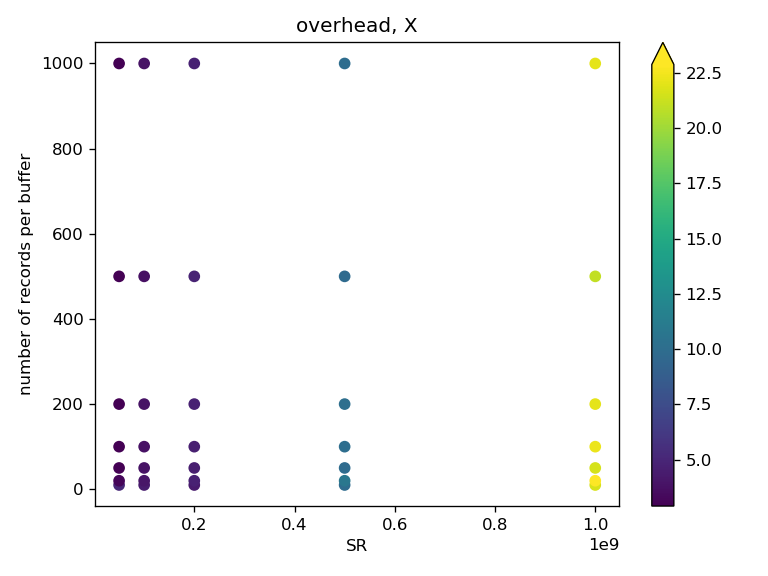

In [113]:
# fig, (ax_overheads, ax_samples_per_record) = plt.subplots(2, 1)
fig, ax_overheads = plt.subplots(1, 1)

nrecords_grid, sr_vals_grid = np.meshgrid(nrecords, sr_vals)

# p_overheads = ax_overheads.pcolormesh(
#     sr_vals_grid, nrecords_grid, overheads,)
#     norm=colors.LogNorm(vmin=overheads.min(), vmax=overheads.max()),
# )
# fig.colorbar(p_overheads, ax=ax_overheads, extend='max')
p_overheads = ax_overheads.scatter(
    sr_vals_grid, nrecords_grid, c=overheads)
#     norm=colors.LogNorm(vmin=overheads.min(), vmax=overheads.max())
# )
fig.colorbar(p_overheads, ax=ax_overheads, extend='max')

ax_overheads.set_xlabel('SR')
ax_overheads.set_ylabel('number of records per buffer')
ax_overheads.set_title('overhead, X')

# # p_samples_per_record = ax_samples_per_record.pcolormesh(
# #     sr_vals_grid, nrecords_grid, samples_per_record,)
# #     norm=colors.LogNorm(vmin=samples_per_record.min(), vmax=samples_per_record.max())
# # ) 
# # fig.colorbar(p_samples_per_record, ax=ax_samples_per_record, extend='max')
# p_samples_per_record = ax_samples_per_record.scatter(
#     sr_vals_grid, nrecords_grid, c=samples_per_record)
# fig.colorbar(p_samples_per_record, ax=ax_samples_per_record)

# ax_samples_per_record.set_xlabel('SR')
# ax_samples_per_record.set_ylabel('number of records per buffer')
# ax_samples_per_record.set_title('samples per record')

fig.tight_layout()

Regardless of the number of records per buffer, the overhead scales linearly with the SR. This can probably be explained by the simple fact of the data size growing with SR, hence it takes more time to transfer and process *more* data.

<IPython.core.display.Javascript object>


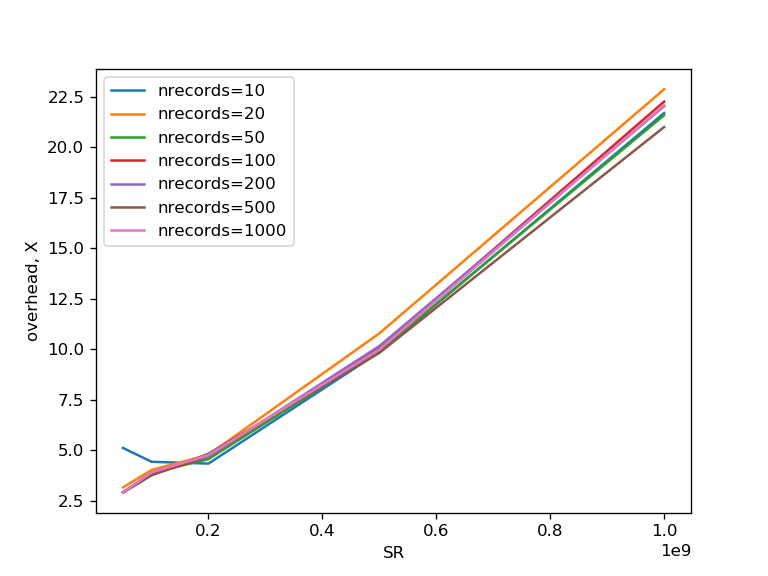

In [116]:
fig, ax = plt.subplots(1,1)

for i, nr in enumerate(nrecords):
    ax.plot(sr_vals_grid[:,i], overheads[:,i], label=f'nrecords={nr}')

ax.set_xlabel('SR')
ax.set_ylabel('overhead, X')

ax.legend()

There is no dependency of the overhead on the number of records per buffer after ~20-50.

<IPython.core.display.Javascript object>


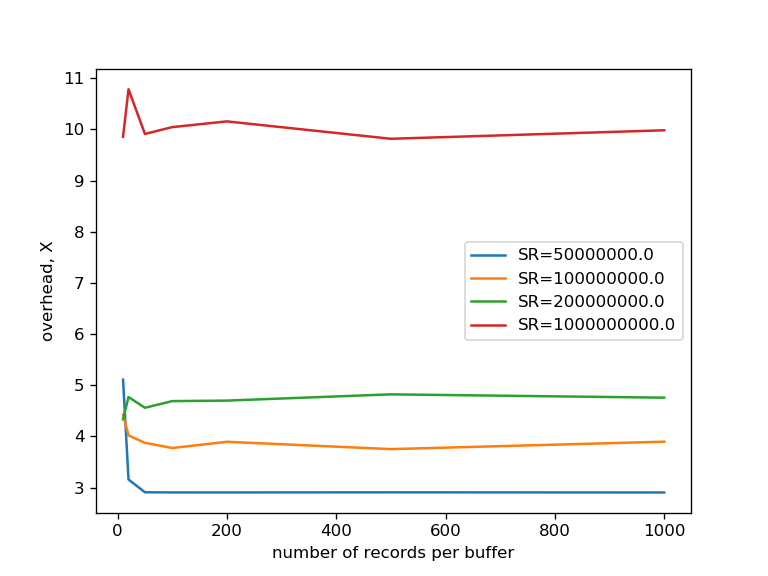

Text(0,0.5,'overhead, X')

In [117]:
fig, ax = plt.subplots(1,1)

for i, sr in enumerate(sr_vals):
    ax.plot(nrecords_grid[i,:], overheads[i,:], label=f'SR={sr}')

ax.legend()

ax.set_xlabel('number of records per buffer')
ax.set_ylabel('overhead, X')

Let's look into numbers of records per buffer that are close to 1.

In [121]:
nrecords = np.array([1, 2, 3, 5, 10, 15, 20, 40])
sr_vals = np.array([50e6, 100e6])

times = np.zeros((sr_vals.size, nrecords.size))
samples_per_record = np.zeros((sr_vals.size, nrecords.size))
overheads = np.zeros((sr_vals.size, nrecords.size))

for j, sr in enumerate(sr_vals):
    for i, nr in enumerate(nrecords):
        times[j, i], samples_per_record[j, i], overheads[j, i] = \
            time_acquisition(n_records_per_buffer=nr, SR=sr)

Allocating 2000000000 elements (4000.0 MB)
done: 0.011202488400158472 s
Setup capture: 153.6 MB total
 * Buffers: 100000 (0.001536 MB/buffer) | (Allocated buffers: 5 = 0.00768 MB)
 * Records: 1 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.7320303190572304 s
Net time: 1.0 sec.
Acquistion: 4.8 sec.
Overhead: 4.8 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.12483149834588403 s
Setup capture: 153.6 MB total
 * Buffers: 50000 (0.003072 MB/buffer) | (Allocated buffers: 5 = 0.01536 MB)
 * Records: 2 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.59896313443096 s
Net time: 1.0 sec.
Acquistion: 2.9 sec.
Overhead: 2.9 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.11190758044904214 s
Setup capture: 153.598464 MB total
 * Buffers: 33333 (0.004608 MB/buffer) | (Allocated buffers: 5 = 0.02304 MB)
 * Records: 3 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.592363832580304 s
Net time: 1.0 sec.
Acquistion: 3.4 

For very low numbers of records per buffer, the overhead is bigger than for higher numbers, and also behaves quite funky. Some further investigation is necessary.

<IPython.core.display.Javascript object>


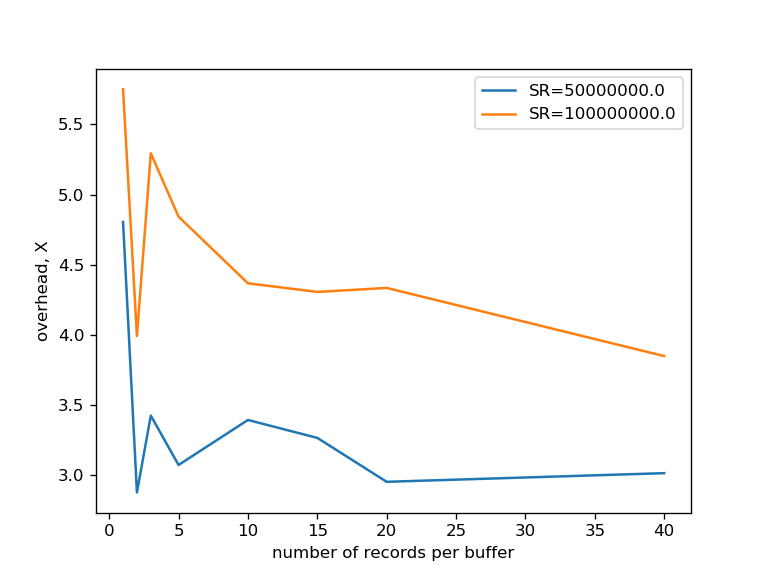

Text(0,0.5,'overhead, X')

In [126]:
nrecords_grid, sr_vals_grid = np.meshgrid(nrecords, sr_vals)

fig, ax = plt.subplots(1,1)

for i, sr in enumerate(sr_vals):
    ax.plot(nrecords_grid[i,:], overheads[i,:], label=f'SR={sr}')

ax.legend()

ax.set_xlabel('number of records per buffer')
ax.set_ylabel('overhead, X')

In [131]:
time_acquisition(n_records_per_buffer=1, SR=50e6)

Allocating 2000000000 elements (4000.0 MB)
done: 0.09977106258520507 s
Setup capture: 153.6 MB total
 * Buffers: 100000 (0.001536 MB/buffer) | (Allocated buffers: 5 = 0.00768 MB)
 * Records: 1 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.5944625884803827 s
Net time: 1.0 sec.
Acquistion: 4.6 sec.
Overhead: 4.6 X


(4.612489699284197, 384, 4.612489699284197)

# Effect of allocated buffers

In [135]:
t_rep = 10e-6  # this is the rep-rate of the AWG test sequence
acq_time = 9e-6  # time it takes to measure raw data by Alazar 
                 # for a single measurement point (i.e. it is to be demodulated later)
npts = int(1e5)  # number of "measurement points"

In [136]:
t_net_total = npts * t_rep

def time_acquisition(n_records_per_buffer = 50, 
                     SR = 50e6,
                     alloc_buffers = 5):
    """
    alloc_buffers: number of buffers to allocate in the Alazar card memory
    """
    t0 = time.perf_counter()
    ctl.allocate_data(int(2e9))
    t1 = time.perf_counter()
    print("done:", t1 - t0, 's')

    nbuffers = npts // n_records_per_buffer
    ctl.setup_acquisition(samples_per_record=None, 
                          records=n_records_per_buffer, 
                          buffers=nbuffers, 
                          acq_time=acq_time, 
                          allocated_buffers=alloc_buffers, 
                          SR=int(SR))
    t2 = time.perf_counter()
    print("done:",  t2 - t1, 's')
    
    t0 = time.perf_counter()
    data = ctl.acquisition() 
    t1 = time.perf_counter()
    
    t_acq_total = t1 - t0
    overhead = t_acq_total / t_net_total

    print(f'Net time: {t_net_total:.1f} sec.')
    print(f'Acquistion: {t_acq_total:.1f} sec.')
    print(f'Overhead: {overhead:.1f} X')
    
    return overhead

In [137]:
nrecords = np.array([1, 2, 3, 5, 7, 10, 20, 50, 100, 200, 500])
alloc_buffers = np.array([1, 2, 3, 5, 7, 10])

overheads = np.zeros((alloc_buffers.size, nrecords.size))

for j, allocb in enumerate(alloc_buffers):
    for i, nr in enumerate(nrecords):
        overheads[j, i] = time_acquisition(n_records_per_buffer=nr, 
                                           SR=50e6,
                                           alloc_buffers=allocb)

Allocating 2000000000 elements (4000.0 MB)
done: 0.1084353955629922 s
Setup capture: 153.6 MB total
 * Buffers: 100000 (0.001536 MB/buffer) | (Allocated buffers: 1 = 0.001536 MB)
 * Records: 1 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.5992798539955402 s
Net time: 1.0 sec.
Acquistion: 12.1 sec.
Overhead: 12.1 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.1095898579369532 s
Setup capture: 153.6 MB total
 * Buffers: 50000 (0.003072 MB/buffer) | (Allocated buffers: 1 = 0.003072 MB)
 * Records: 2 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.5959362142421014 s
Net time: 1.0 sec.
Acquistion: 6.5 sec.
Overhead: 6.5 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.11215245159473852 s
Setup capture: 153.598464 MB total
 * Buffers: 33333 (0.004608 MB/buffer) | (Allocated buffers: 1 = 0.004608 MB)
 * Records: 3 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.6004807490244275 s
Net time: 1.0 sec.
Acquistion:

Net time: 1.0 sec.
Acquistion: 2.9 sec.
Overhead: 2.9 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.10841633373638615 s
Setup capture: 153.598464 MB total
 * Buffers: 33333 (0.004608 MB/buffer) | (Allocated buffers: 3 = 0.013824 MB)
 * Records: 3 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.5942685488662391 s
Net time: 1.0 sec.
Acquistion: 4.2 sec.
Overhead: 4.2 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.10833275496406714 s
Setup capture: 153.6 MB total
 * Buffers: 20000 (0.00768 MB/buffer) | (Allocated buffers: 3 = 0.02304 MB)
 * Records: 5 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.6051025086344453 s
Net time: 1.0 sec.
Acquistion: 3.5 sec.
Overhead: 3.5 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.10260736451164121 s
Setup capture: 153.59232000000003 MB total
 * Buffers: 14285 (0.010752000000000001 MB/buffer) | (Allocated buffers: 3 = 0.03225600000000001 MB)
 * Records: 7 (0.001536 MB/record)
 * Samples:

Setup capture: 153.6 MB total
 * Buffers: 20000 (0.00768 MB/buffer) | (Allocated buffers: 7 = 0.05376 MB)
 * Records: 5 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.5978937171239522 s
Net time: 1.0 sec.
Acquistion: 3.6 sec.
Overhead: 3.6 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.11140855162375374 s
Setup capture: 153.59232000000003 MB total
 * Buffers: 14285 (0.010752000000000001 MB/buffer) | (Allocated buffers: 7 = 0.07526400000000001 MB)
 * Records: 7 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.6044685807355563 s
Net time: 1.0 sec.
Acquistion: 3.4 sec.
Overhead: 3.4 X
Allocating 2000000000 elements (4000.0 MB)
done: 0.11055321328603895 s
Setup capture: 153.6 MB total
 * Buffers: 10000 (0.01536 MB/buffer) | (Allocated buffers: 7 = 0.10752 MB)
 * Records: 10 (0.001536 MB/record)
 * Samples: 384 (= 7.68 us)
 * Channels: 2
done: 0.6003106588868832 s
Net time: 1.0 sec.
Acquistion: 3.3 sec.
Overhead: 3.3 X
Allocating 2000000

<IPython.core.display.Javascript object>


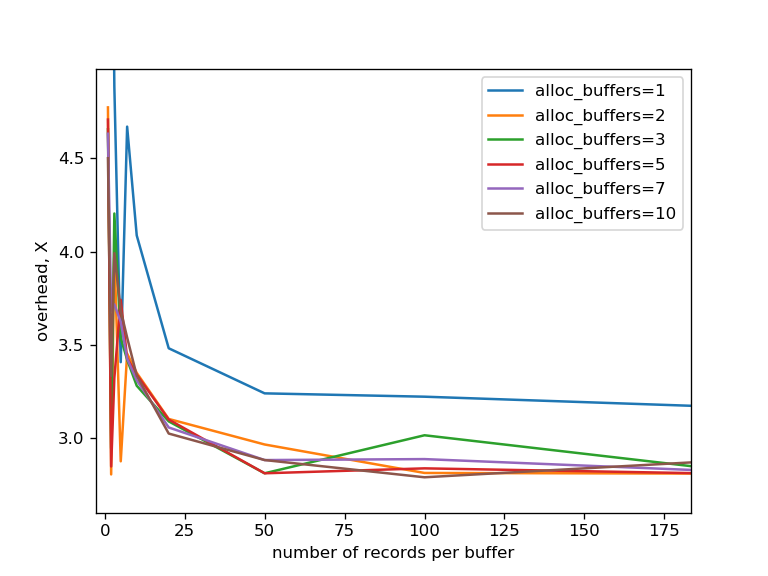

Text(0,0.5,'overhead, X')

In [138]:
nrecords_grid, alloc_buffers_grid = np.meshgrid(nrecords, alloc_buffers)

fig, ax = plt.subplots(1,1)

for i, allb in enumerate(alloc_buffers):
    ax.plot(nrecords_grid[i,:], overheads[i,:], label=f'alloc_buffers={allb}')

ax.legend()

ax.set_xlabel('number of records per buffer')
ax.set_ylabel('overhead, X')